# Analyse the embeddings

### 1.1 import

In [1]:
import warnings

from matplotlib.pyplot import subplots

%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import json
from IMPACT import utils
from IMPACT import model
from IMPACT import dataset
import torch
import pandas as pd

import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2. logger set up

In [2]:
utils.setuplogger(verbose = True, log_name="Embedding_explore")

In [3]:
utils.set_seed(0)

### 1.3. Metric computing

In [4]:
dataset_name = 'postcovid'
algo_name = 'DBPR_cornac'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_Iter_fold{i_fold}_seed_{0}.csv', header=None).to_numpy())

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


#### 1.3.3. DOA

In [ ]:
reload(utils)
utils.compute_doa(embs, dataset_name, algo_name)

#### 1.3.2. Correlation coeff

In [ ]:
reload(utils)
utils.compute_corr_coeff(embs=embs, dataset_name=dataset_name,fold_nb=5)

#### 1.3.1. RM

In [ ]:
reload(utils)
utils.compute_rm(embs=embs, dataset_name=dataset_name)

### 1.4. Qualitative study
#### 1.4.1. Imports

In [8]:
import pandas as pd

df = pd.read_csv("./data/portrait_hyperparam_study.csv", header=0, sep=",").astype(float)

In [9]:
df = df.rename(columns ={'rmse':'rmse_avg', 'mae':'mae_avg', 'pc-er':'pc-er_avg'})

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib
# Reset RC parameters to the default settings.
plt.rcdefaults()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
XXL_SIZE = 14

plt.rc('font', size=XXL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_evolution_with_nb_params(metric, df):
    """
    Plots the evolution of a metric (with std dev),
    plus a secondary axis for the number of parameters.
    """
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    ##########################################################
    # First axis (ax1) for your main metric
    ##########################################################

    fig, ax1 = plt.subplots()

    # Extract arrays for the main metric
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    line1 = ax1.plot(x, y, label=f"{metric.upper()} mean", color='tab:blue')
    ax1.fill_between(
        x, y - std, y + std,
        alpha=0.2, color='tab:blue',
        label=f"{metric.upper()} confidence interval ($\pm$ std)"
    )

    # Axis labels and style
    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel(metric.upper(), color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # X-axis ticks and limits
    ax1.set_xticks(x)

    # Show only 1 label out of 5, keep all ticks
    ax1.set_xticklabels([
        str(int(val)) if i % 5 == 0 else ""  # empty string hides 4 out of 5 labels
        for i, val in enumerate(x)
    ])

    ax1.set_xlim(left=4)

    # Y-axis limits to ensure they incorporate mean -/+ std
    y_min = df[metric + '_avg'].min() - df[metric + '_std'].max()
    y_max = (df[metric + '_avg'].max() + df[metric + '_std'].max()
             + 0.1 * (df[metric + '_avg'].max() - df[metric + '_avg'].min()))
    ax1.set_ylim(bottom=y_min, top=y_max)

    # Example vertical line from y_min to the avg at x=12
    selected_x = 12
    selected_y = df[df['num_responses'] == selected_x][metric + '_avg'].values[0]

    # Example horizontal line from x=4 to x=12 at that same selected_y
    ax1.hlines(
        y=selected_y,
        xmin=4,
        xmax=selected_x,
        color='black',
        linestyle='--',
        label='Selected hyperparameter'
    )

    # Make sure the main axes lines are visible
    ax1.set_facecolor('none')
    for spine in ['top', 'right', 'bottom', 'left']:
        ax1.spines[spine].set_visible(True)

    ##########################################################
    # Second axis (ax2) for the number of parameters
    ##########################################################

    ax2 = ax1.twinx()  # shares the same x-axis as ax1

    # Define a function to compute the number of parameters
    def nb_params(d_r:int, M:int):
        dim_n  = 9
        user_n = 1152
        quest_n = 116
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second axis
    x2 = np.arange(5, 26)  # match the domain of x for consistency
    y2 = [nb_params(d_r=6, M=m) for m in x2]  # e.g., d_r=6

    line2 = ax2.plot(
        x2, y2,
        color='tab:green',
        label='Number of IMPACT parameters'
    )

    # Label and style for second axis
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Formatter to display large numbers as 'xx×10^3'
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e3)}$\\times10^3$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))

    # Set y-limits for the second axis (adjust as needed)
    ax2.set_ylim(bottom=0, top=45000)

    # Example vertical line for the second axis at x=12, from 0 to y2
    x_v = selected_x
    y_v = nb_params(d_r=6, M=x_v)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    # from x=selected_x to the right
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        linestyle='--',
        color='black',
    )

    ##########################################################
    # Combine legends
    ##########################################################

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/" + str(metric) + "_portrait_hyperparam.pdf")
    plt.show()

# Example usage:
# plot_evolution_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 16,           # Base font size for all text
    "axes.titlesize": 18,      # Title font
    "axes.labelsize": 16,      # Axis label font
    "xtick.labelsize": 12,     # X tick labels
    "ytick.labelsize": 12,     # Y tick labels
    "legend.fontsize": 12,     # Legend text
    "figure.titlesize": 18,    # Figure title
})

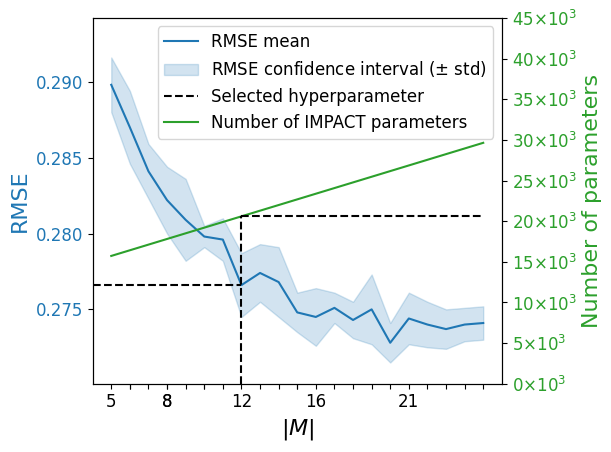

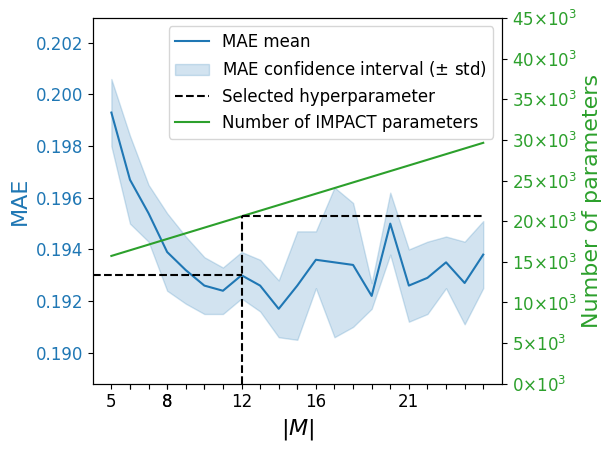

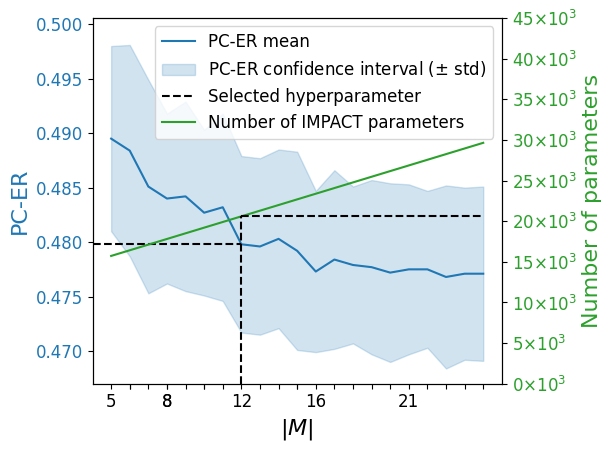

In [17]:

plot_evolution_with_nb_params('rmse',df[df['d_in']==6])
plot_evolution_with_nb_params('mae',df[df['d_in']==6])
plot_evolution_with_nb_params('pc-er',df[df['d_in']==6])

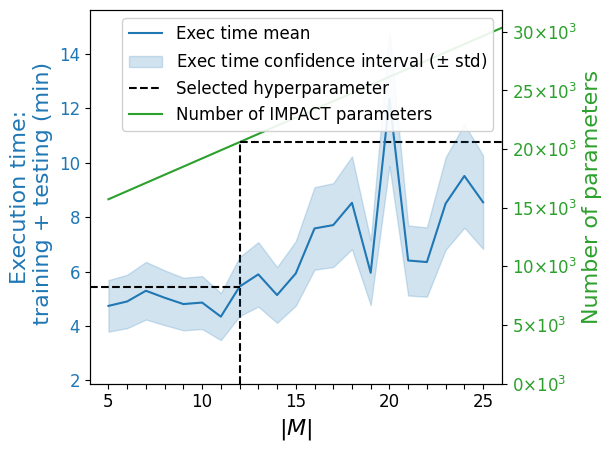

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------
# Global figure style setup (clean and consistent)
# ------------------------------------------------------------
plt.rcdefaults()  # reset to Matplotlib defaults

plt.rcParams.update({
    "font.size": 16,           # Base font size for all text
    "axes.titlesize": 18,      # Title font
    "axes.labelsize": 16,      # Axis label font
    "xtick.labelsize": 12,     # X tick labels
    "ytick.labelsize": 12,     # Y tick labels
    "legend.fontsize": 12,     # Legend text
    "figure.titlesize": 18,    # Figure title
})

# ------------------------------------------------------------
# Main plotting function
# ------------------------------------------------------------
def plot_evolution_time_with_nb_params(metric, df):
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    # Create figure and first axis (for execution times)
    fig, ax1 = plt.subplots()

    # Extract arrays for the first axis
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'] / 60)   # Convert seconds to minutes
    std = np.array(df[metric + '_std'] / 60)   # Convert seconds to minutes

    # Plot mean +/- std for execution time
    ax1.plot(x, y, label='Exec time mean', color='tab:blue')
    ax1.fill_between(x, y - std, y + std, alpha=0.2, color='tab:blue',
                     label=f"Exec time confidence interval ($\pm$ std)")

    # Axis labels
    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel("Execution time:\n training + testing (min)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-ticks and limits with extra left margin
    ax1.set_xticks(x)

    # Show only 1 label out of 5, keep all ticks
    ax1.set_xticklabels([
        str(int(val)) if i % 5 == 0 else ""  # empty string hides 4 out of 5 labels
        for i, val in enumerate(x)
    ])

    x_margin = max(1, 0.05 * (x.max() - x.min()))  # 1 or 5% of range
    ax1.set_xlim(left=x.min() - x_margin, right=x.max() + 1)

    # Dynamic y-limits (mean ± std with 10% margin)
    y_min = y.min() - std.max()
    y_max = y.max() + std.max() + 0.1 * (y.max() - y.min())
    ax1.set_ylim(bottom=y_min, top=y_max)

    # Highlight selected hyperparameter (example x=12)
    selected_x = 12
    if selected_x in x:
        selected_y = df[df['num_responses'] == selected_x][metric + '_avg'].values[0] / 60
        ax1.hlines(
            y=selected_y, xmin=x.min() - x_margin, xmax=selected_x,
            color='black', linestyle='--', label='Selected hyperparameter'
        )

    # Ensure axes are visible and clean
    ax1.set_facecolor('none')
    for spine in ['top', 'right', 'bottom', 'left']:
        ax1.spines[spine].set_visible(True)

    # ------------------------------------------------------------
    # Second axis (for number of parameters)
    # ------------------------------------------------------------
    ax2 = ax1.twinx()  # shares the same x-axis

    def nb_params(d_r: int, M: int):
        dim_n = 9
        user_n = 1152
        quest_n = 116
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second plot
    x2 = np.arange(int(x.min()), int(x.max()) + 2)
    y2 = [nb_params(d_r=6, M=m) for m in x2]

    ax2.plot(x2, y2, color='tab:green', label='Number of IMPACT parameters')
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Format large numbers
    def tick_formatter(x_val, pos):
        return f"{int(x_val / 1e3)}$\\times10^3$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=0, top=max(y2) * 1.05)

    # Add reference lines for parameter axis
    if selected_x in x2:
        y_v = nb_params(d_r=6, M=selected_x)
        ax2.vlines(x=selected_x, ymin=0, ymax=y_v, linestyle='--', color='black')
        ax2.hlines(y=y_v, xmin=selected_x, xmax=x.max() + 1, linestyle='--', color='black')

    # ------------------------------------------------------------
    # Combine legends from both axes
    # ------------------------------------------------------------
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.set_zorder(2)
    ax2.set_zorder(1)
    ax1.patch.set_visible(False)
    ax2.patch.set_visible(False)

    # Make a single legend on the primary axis
    

    # Force a draw so Matplotlib lines up everything
    plt.draw()

    # Save and display
    legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', framealpha=0.9)
    legend.set_zorder(9999)

    fig.tight_layout()
    
    plt.savefig(f"../../figs/{metric}_portrait_hyperparam.pdf")
    plt.show()

# Example usage (assuming df is available)
plot_evolution_time_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


In [26]:
import pandas as pd

df = pd.read_csv("./data/movielens_hyperparam_study.csv", header=0, sep=",").astype(float)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def nb_params(d_r: int, M: int):
    dim_n  = 11
    user_n = 4231
    quest_n= 2421
    # Simple example formula:
    return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

# Example data for second axis
Y = [nb_params(x,5) for x in range(2,22)]

def plot_evolution(metric, df):
    # Sort by d_in just to be consistent
    df = df.sort_values('d_in')

    fig, ax = plt.subplots()

    # Primary axis data
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot on primary axis
    ax.plot(x, y, label=f"{metric.upper()} mean", color='tab:blue', zorder=3)
    ax.fill_between(x, y - std, y + std, alpha=0.2,
                    label=f"{metric.upper()} ± std", color='tab:blue', zorder=2)

    ax.set_xlabel(r"$d_r$")
    ax.set_ylabel(metric.upper(), color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xticks(np.arange(2, 22))

    ax.set_xticklabels([
        str(int(val)) if i % 5 == 0 else ""  # empty string hides 4 out of 5 labels
        for i, val in enumerate(x)
    ])

    min_val = y.min() - 0.1*(y.max() - y.min())
    max_val = (y + std).max() + 0.1*(y.max() - y.min())
    ax.set_ylim(bottom=min_val, top=max_val)
    ax.set_xlim(left=1.5)

    # Example lines on primary axis
    ax.vlines(x=10, ymin=min_val, ymax=df.loc[df['d_in'] == 10, metric + '_avg'].item(),
              linestyle='--', color='black', zorder=1)
    ax.hlines(y=df.loc[df['d_in'] == 10, metric + '_avg'].item(),
              xmin=0, xmax=10, color='black', linestyle='--',
              label='Selected hyperparameter', zorder=1)
    ax.vlines(x=11, ymin=min_val, ymax=max_val, color='red', linestyle='-',
              label="Users' embedding dim $|C|$", zorder=1)

    # -----------------------
    # Create twin axis
    ax2 = ax.twinx()
    ax2.patch.set_visible(False)
    # (Optional) If you want a separate background color for ax2, leave patch visible:
    # Otherwise: ax2.patch.set_visible(False)  # to remove background

    # Plot data on twin axis
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of IMPACT parameters', zorder=-1)
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Format large numbers
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(50000, 450000)

    # Example lines on ax2
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(x=x_v, ymin=0, ymax=y_v,
               linestyle='--', color='black', zorder=-1)
    ax2.hlines(y=y_v, xmin=x_v, xmax=25,
               color='black', linestyle='--', zorder=-1)

    # -----------------------
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax.set_zorder(2)
    ax2.set_zorder(1)
    ax.patch.set_visible(False)
    ax2.patch.set_visible(False)

    # Make a single legend on the primary axis
    

    # Force a draw so Matplotlib lines up everything
    plt.draw()

    # Re-insert the legend as the last artist on ax so it’s definitively on top
    #ax.add_artist(leg)
    # Give it a high zorder
    leg = ax.legend(lines1 + lines2, labels1 + labels2,
                    loc='best', framealpha=0.9)
    leg.set_zorder(9999)

    fig.tight_layout()
    plt.savefig(f"../../figs/{metric}_movielens_hyperparam.pdf")
    plt.show()


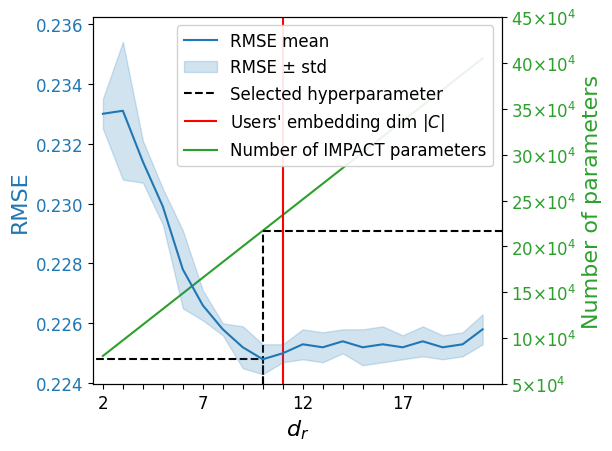

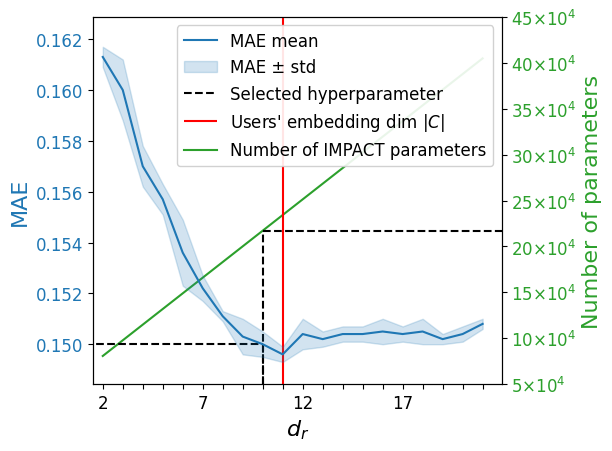

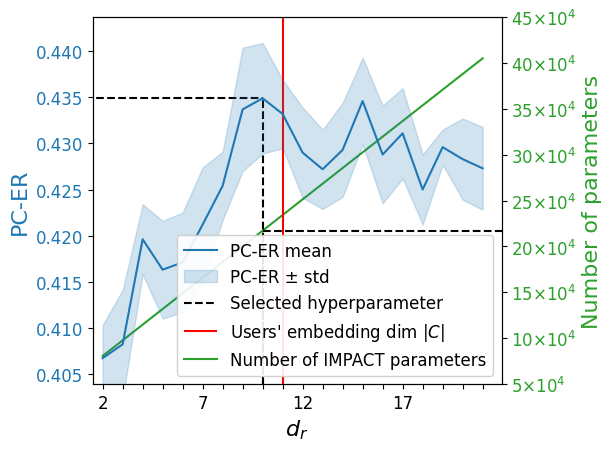

In [29]:
plot_evolution('rmse',df)
plot_evolution('mae',df)
plot_evolution('pc-er',df)

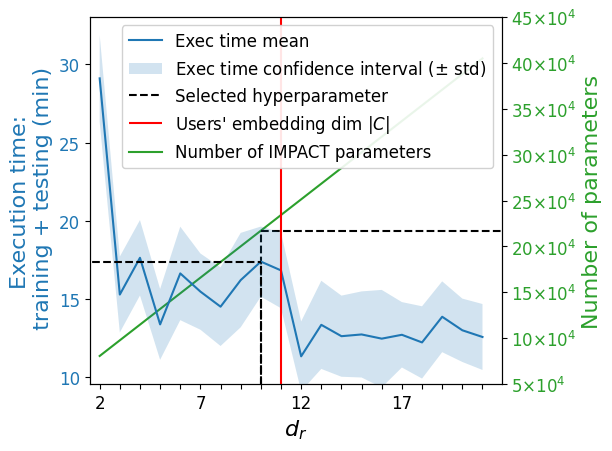

In [31]:
def plot_evolution_time(metric,df) :

    df = df.sort_values('d_in')
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg']/60)
    std = np.array(df[metric + '_std']/60)

    # Plot mean +/- std
    ax.plot(x, y, label='Exec time mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label="Exec time confidence interval ($\pm$ std)")


    ax.set_ylabel("Execution time:\n training + testing (min)", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))
    ax.set_xticklabels([
        str(int(val)) if i % 5 == 0 else ""  # empty string hides 4 out of 5 labels
        for i, val in enumerate(x)
    ])

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg']/60,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg']/60,
        xmin=0,
        xmax=10,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),
        color='red',
        label = f'Users\' embedding dim $|C|$'
    )


    ax2 = ax.twinx()  # shares the same x-axis with ax

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of IMPACT parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=50000, top=450000)

    # Example vertical line for the second axis at x=12
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    ax.set_zorder(2)
    ax2.set_zorder(1)
    ax.patch.set_visible(False)
    ax2.patch.set_visible(False)

    # Make a single legend on the primary axis
    

    # Force a draw so Matplotlib lines up everything
    plt.draw()

    # Re-insert the legend as the last artist on ax so it’s definitively on top
    #ax.add_artist(leg)
    # Give it a high zorder
    leg = ax.legend(lines1 + lines2, labels1 + labels2,
                    loc='best', framealpha=0.9)
    leg.set_zorder(9999)

    fig.tight_layout()
    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

plot_evolution_time('exec_time',df)

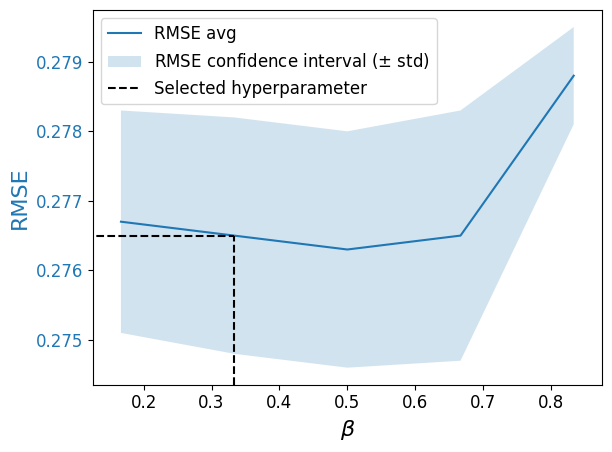

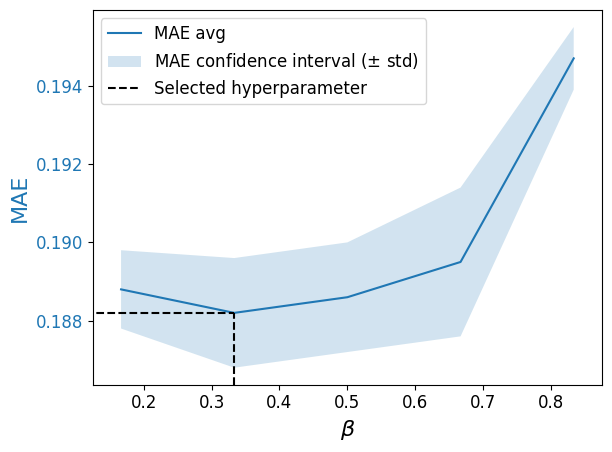

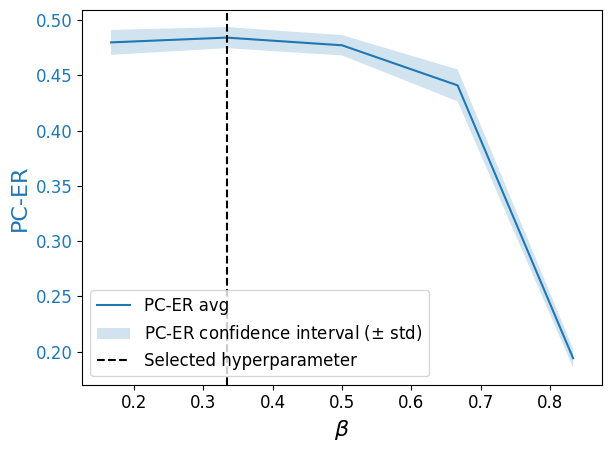

In [32]:

def plot_beta_variation_rmse() :

    
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array([1/6,2/6,3/6,4/6,5/6])
    y_rmse   = np.array([0.2767,0.2765,0.2763,0.2765,0.2788])
    std_rmse = np.array([0.0016,0.0017,0.0017,0.0018,0.0007])

    # Plot mean +/- std
    ax.plot(x, y_rmse, label='RMSE avg')
    ax.fill_between(x, y_rmse - std_rmse, y_rmse + std_rmse, alpha=0.2, label="RMSE confidence interval ($\pm$ std)")


    ax.set_ylabel("RMSE", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$\beta$')

    # If you want the x-axis to start at 0
    ax.set_xlim(left=0.75/6, right=5.25/6)
    ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1])

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    #ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=1/3,
        ymin=ax.get_ylim()[0],
        ymax=0.2765,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=0.2765,
        xmin=0,
        xmax=1/3,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.legend( loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/rmse_beta_hyper_var.pdf")

def plot_beta_variation_mae() :

    
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array([1/6,2/6,3/6,4/6,5/6])
    y_mae   = np.array([0.1888,0.1882,0.1886,0.1895,0.1947])
    std_mae = np.array([0.0010,0.0014,0.0014,0.0019,0.0008])

    # Plot mean +/- std
    ax.plot(x, y_mae, label='MAE avg')
    ax.fill_between(x, y_mae - std_mae, y_mae + std_mae, alpha=0.2, label="MAE confidence interval ($\pm$ std)")


    ax.set_ylabel("MAE", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$\beta$')

    # If you want the x-axis to start at 0
    ax.set_xlim(left=0.75/6, right=5.25/6)
    ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1])

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    #ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=1/3,
        ymin=ax.get_ylim()[0],
        ymax=0.1882,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=0.1882,
        xmin=0,
        xmax=1/3,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.legend( loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/mae_beta_hyper_var.pdf")

def plot_beta_variation_doa() :

    
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array([1/6,2/6,3/6,4/6,5/6])
    y_mae   = np.array([0.6453,0.6463,0.6438,0.6332,0.5585])
    std_mae = np.array([0.0026,0.0027,0.0025,0.0048,0.0033])

    # Plot mean +/- std
    ax.plot(x, y_mae, label='DOA avg')
    ax.fill_between(x, y_mae - std_mae, y_mae + std_mae, alpha=0.2, label="DOA confidence interval ($\pm$ std)")


    ax.set_ylabel("DOA", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$\beta$')

    # If you want the x-axis to start at 0
    ax.set_xlim(left=0.75/6, right=5.25/6)
    ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1])

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    #ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=1/3,
        ymin=ax.get_ylim()[0],
        ymax=0.6463,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=0.6463,
        xmin=0,
        xmax=1/3,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.legend( loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/doa_beta_hyper_var.pdf")

def plot_beta_variation_pcer() :

    
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array([1/6,2/6,3/6,4/6,5/6])
    y_mae   = np.array([0.479880,0.484204,0.477260,0.440967,0.193954])
    std_mae = np.array([0.011299,0.009576,0.009209,0.014437,0.008524])

    # Plot mean +/- std
    ax.plot(x, y_mae, label='PC-ER avg')
    ax.fill_between(x, y_mae - std_mae, y_mae + std_mae, alpha=0.2, label="PC-ER confidence interval ($\pm$ std)")


    ax.set_ylabel("PC-ER", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$\beta$')

    # If you want the x-axis to start at 0
    ax.set_xlim(left=0.75/6, right=5.25/6)
    ax.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1])

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    #ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=1/3,
        ymin=ax.get_ylim()[0],
        ymax=0.6463,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=0.6463,
        xmin=0,
        xmax=1/3,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.legend( loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/pcer_beta_hyper_var.pdf")

plot_beta_variation_rmse()
plot_beta_variation_mae()
plot_beta_variation_pcer()

In [165]:
from torch.utils import data
import torch

def _evaluate_preds_spec(self, data_loader: data.DataLoader, dim: int):
    # Accumulators for two splits: mask_true (==dim) and mask_false (!=dim)
    acc = {
        True:  {"loss": [], "pred": [], "label": [], "nb_mod": []},
        False: {"loss": [], "pred": [], "label": [], "nb_mod": []},
    }

    def process_mask(mask: torch.Tensor, user_ids, item_ids, labels, dim_ids):
        if not mask.any():
            return
        # align nb_modalities with the *masked* item_ids
        nb_mod_all = data_loader.dataset.nb_modalities[item_ids]
        nb_mod = nb_mod_all[mask]

        u = user_ids[mask]
        i = item_ids[mask]
        d = dim_ids[mask]
        y = labels[mask]

        preds = self.model(u, i, d)
        loss  = self._loss_function(preds, y).float()

        bucket = acc[bool((d == dim).all().item())]  # True if this bucket is ==dim
        bucket["loss"].append(loss)
        bucket["pred"].append(preds.detach())
        bucket["label"].append(y.detach())
        bucket["nb_mod"].append(nb_mod.detach())

    with torch.inference_mode():
        for data_batch in data_loader:
            user_ids = data_batch[:, 0].long()
            item_ids = data_batch[:, 1].long()
            labels   = data_batch[:, 2]
            dim_ids  = data_batch[:, 3].long()

            mask_true  = (dim_ids == dim)
            mask_false = ~mask_true

            # process each split
            process_mask(mask_true,  user_ids, item_ids, labels, dim_ids)
            process_mask(mask_false, user_ids, item_ids, labels, dim_ids)

    def pack(bucket):
        if len(bucket["pred"]) == 0:
            return (torch.tensor([], dtype=torch.float32),
                    torch.tensor([], dtype=torch.float32),
                    torch.tensor([], dtype=torch.float32),
                    torch.tensor([], dtype=torch.long))
        loss_tensor          = torch.stack(bucket["loss"])
        pred_tensor          = torch.cat(bucket["pred"],  dim=0)
        label_tensor         = torch.cat(bucket["label"], dim=0)
        nb_modalities_tensor = torch.cat(bucket["nb_mod"], dim=0)
        return loss_tensor, pred_tensor, label_tensor, nb_modalities_tensor

    return (*pack(acc[True]), *pack(acc[False]))


def evaluate_emb_qual(self, test_dataset: data.Dataset, dim: int, noise_level: float):
    """
    Temporarily add multiplicative Gaussian noise to users_emb[:, dim],
    evaluate on items with dim_ids == dim and != dim separately, and restore.
    """
    # Cache original column
    with torch.no_grad():
        original_col = self.model.users_emb.weight[:, dim].detach().clone()

    try:
        # Add noise based on the *original* column so runs don't accumulate noise
        with torch.no_grad():
            col   = original_col
            std_c = col.std(unbiased=False)
            noise = torch.randn_like(col) * (noise_level * std_c)
            self.model.users_emb.weight[:, dim].copy_(col + noise)

        # Build loader and evaluate
        test_loader = data.DataLoader(
            test_dataset,
            batch_size=100_000,
            shuffle=False,
            pin_memory=self.config['pin_memory'],
            num_workers=self.config['num_workers'],
        )

        (loss_t, pred_t, label_t, nbmod_t,
         loss_f, pred_f, label_f, nbmod_f) = _evaluate_preds_spec(self, test_loader, dim)

        # Prepare metric inputs
        def to_metric_types(pred, label, nbmod):
            return pred.to(torch.double), label.to(torch.double), nbmod.to(torch.long)

        results_true, results_false = {}, {}

        if pred_t.numel() > 0:
            p, y, n = to_metric_types(pred_t, label_t, nbmod_t)
            results_true = {
                metric: self.pred_metric_functions[metric](p, y, n).cpu().item()
                for metric in ['rmse', 'mae']
            }
        else:
            results_true = {metric: None for metric in ['rmse', 'mae']}

        if pred_f.numel() > 0:
            p, y, n = to_metric_types(pred_f, label_f, nbmod_f)
            results_false = {
                metric: self.pred_metric_functions[metric](p, y, n).cpu().item()
                for metric in ['rmse', 'mae']
            }
        else:
            results_false = {metric: None for metric in ['rmse', 'mae']}

    finally:
        # Always restore
        with torch.no_grad():
            self.model.users_emb.weight[:, dim].copy_(original_col)

    return results_true, results_false


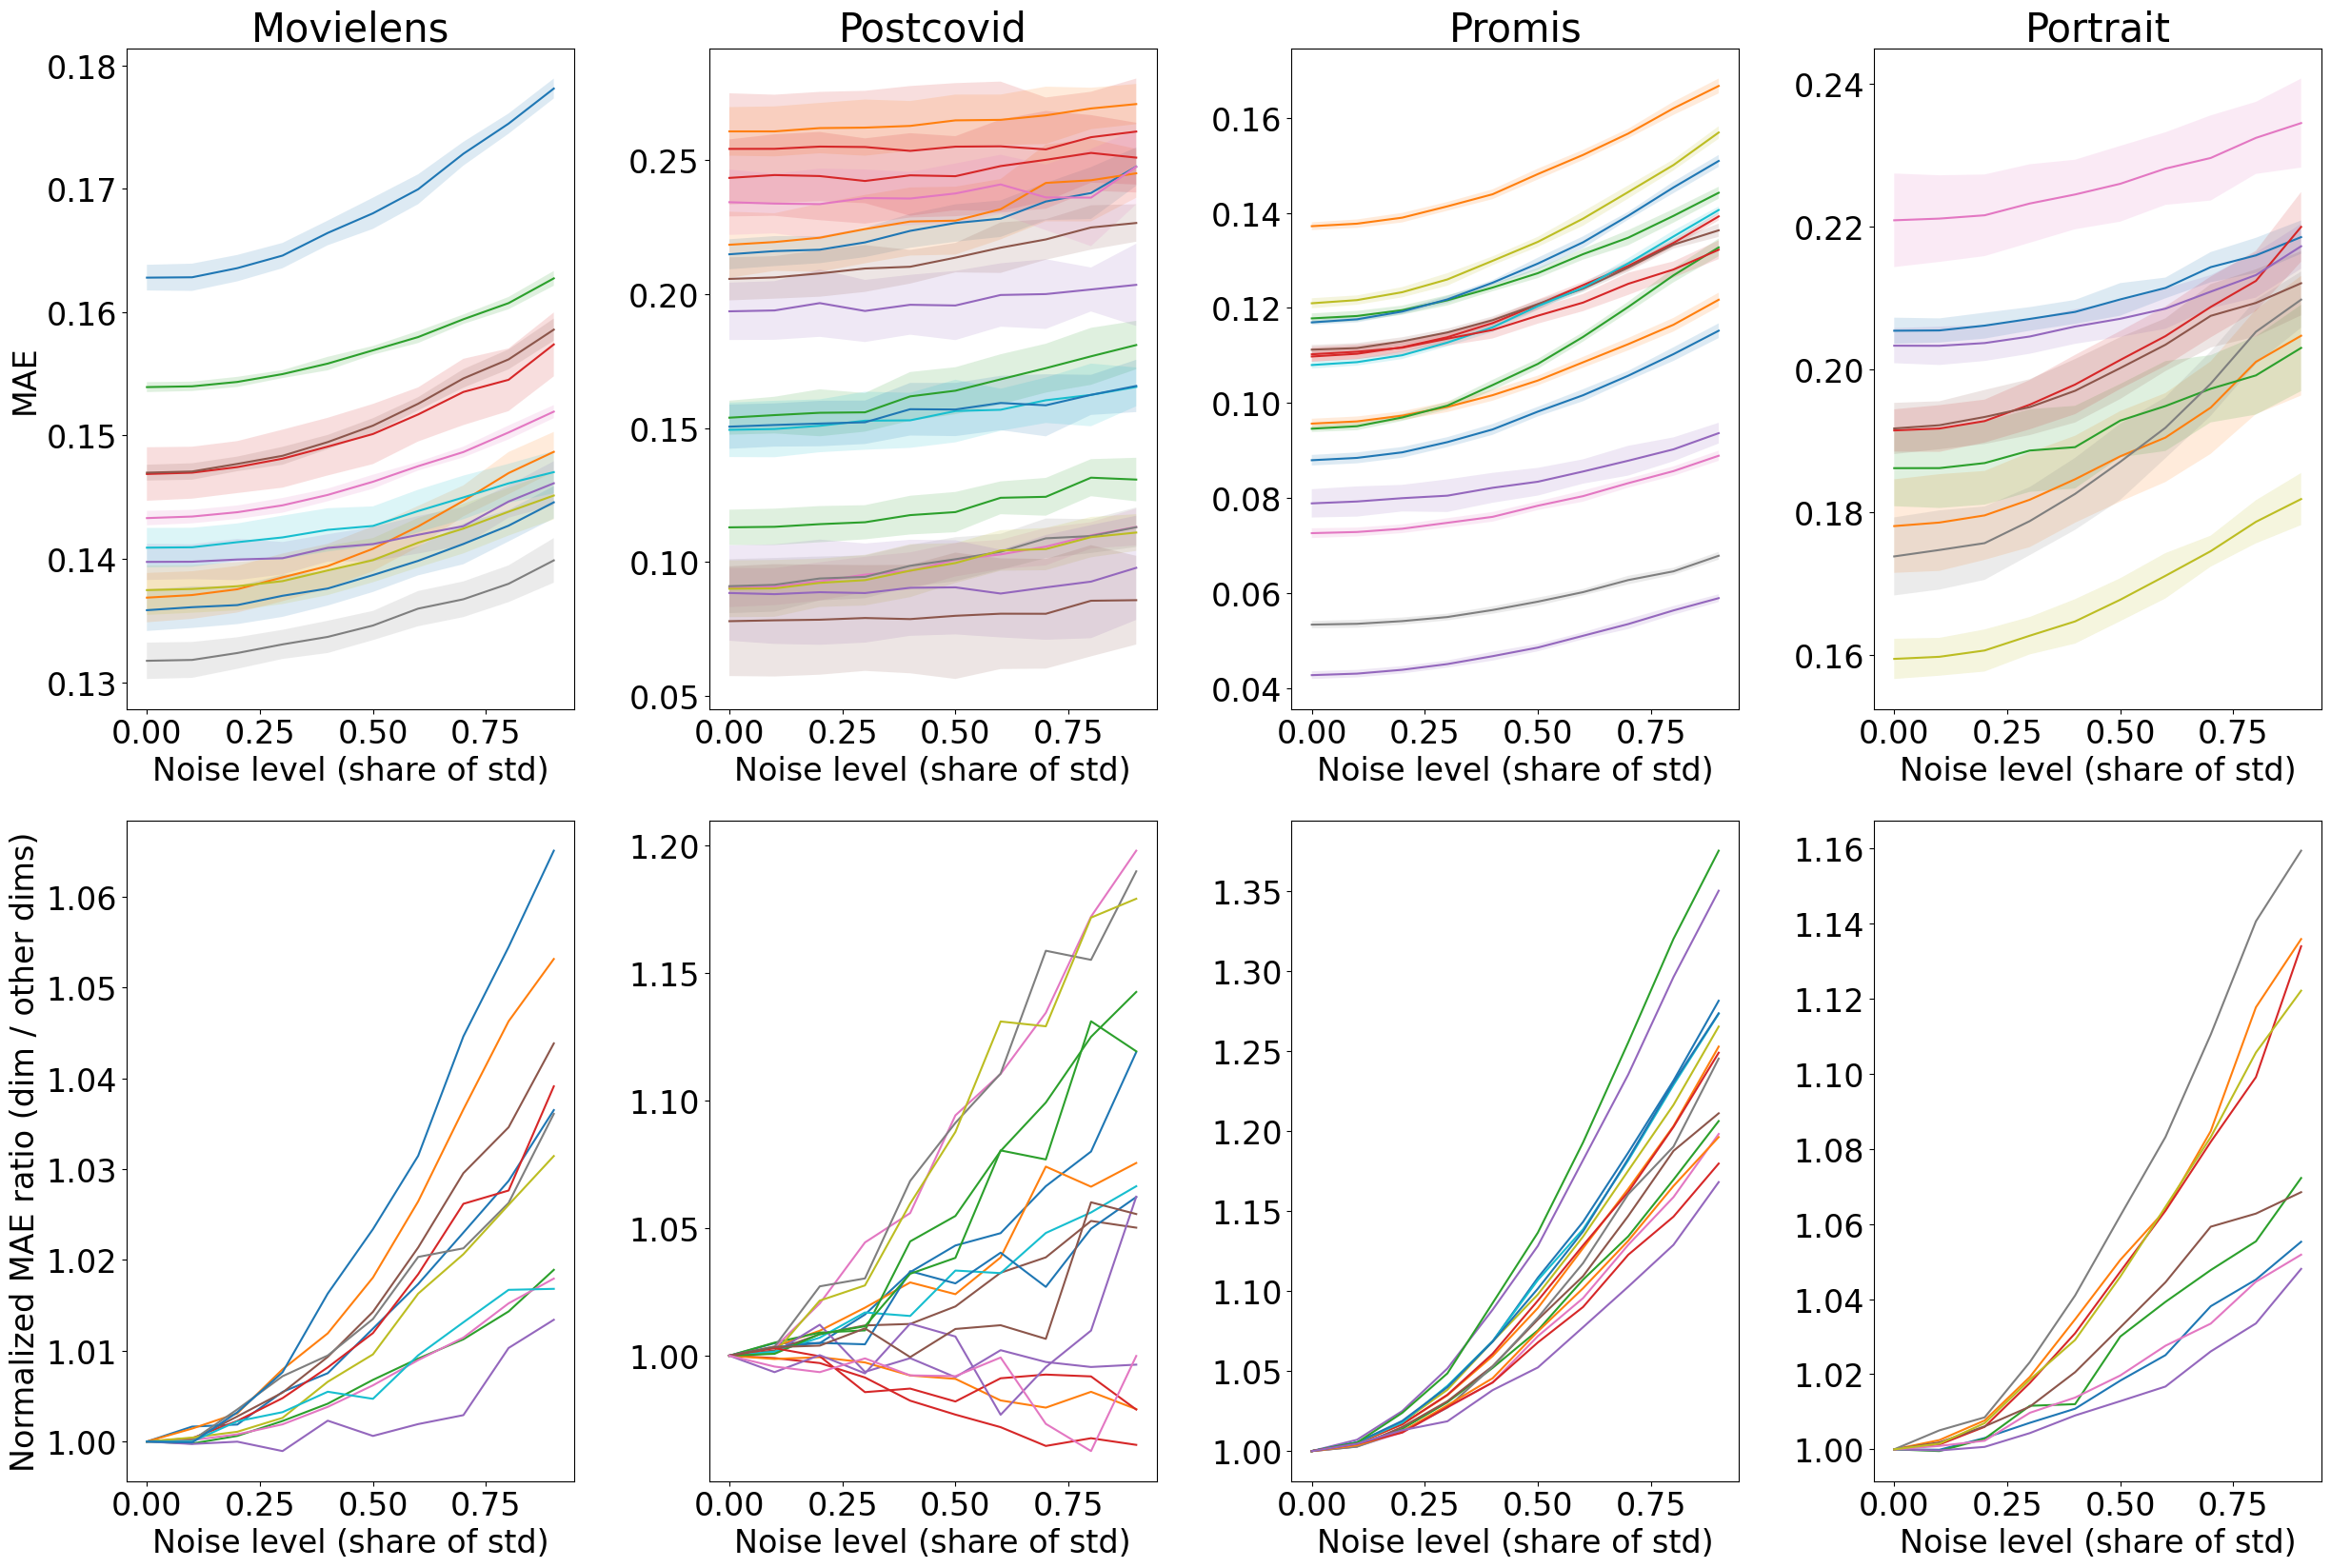

In [109]:
#!/usr/bin/env python3
import os
import re
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import glob


def find_file(target_relpath):
    """
    Try to locate the file by checking current dir and successive parent dirs.
    Returns an absolute path if found, or None otherwise.
    """
    target_relpath = Path(target_relpath)
    current = Path.cwd().resolve()

    for parent in [current] + list(current.parents):
        candidate = parent / target_relpath
        if candidate.exists():
            return candidate

    print(f"[ERROR] Could not locate file {target_relpath}")
    return None


def extract_mae_arrays(filepath):
    """Extract MAE dim and MAE ratio matrices from a log file."""
    with open(filepath, 'r') as f:
        text = f.read()

    mae_dim_match = re.search(r"MAE dim\s*\[\[(.*?)\]\]", text, re.DOTALL)
    mae_ratio_match = re.search(r"MAE ratio\s*\[\[(.*?)\]\]", text, re.DOTALL)

    if not mae_dim_match or not mae_ratio_match:
        print(filepath)
        raise ValueError("Could not find MAE dim or MAE ratio in the file.")
        

    def parse_block(block_text):
        """Convert a text block of numbers into a list of lists (floats)."""
        cleaned = re.sub(r"[\n\r]+", " ", block_text)
        cleaned = re.sub(r"\s+", " ", cleaned.strip())
        rows = re.findall(r"\[([^\]]+)\]", "[{}]".format(cleaned))
        return [list(map(float, row.strip().split())) for row in rows]

    mae_dim = parse_block(mae_dim_match.group(1))
    mae_ratio = parse_block(mae_ratio_match.group(1))

    return mae_dim, mae_ratio


fig, axs = plt.subplots(2,4, figsize = (25,17))

nb_folds = 5
nb_seeds = 3
nb_steps = 10

plt.rcParams.update({
    "axes.titlesize": 30,      # title size for subplots
    "figure.titlesize": 30,    # overall figure title (if used)
    "font.size": 24,           # Base font size for all text
    "axes.labelsize": 24,      # Axis label font
    "xtick.labelsize": 24,     # X tick labels
    "ytick.labelsize": 24,     # Y tick labels
    "legend.fontsize": 16,     # Legend text
    "figure.titlesize": 25,    # Figure title
})


datasets_nb_dims = {"movielens":11, "postcovid":17, "promis":15, "portrait":9}

for i_dataset, dataset in enumerate(["movielens", "postcovid", "promis", "portrait"]) : 

    n_dims = datasets_nb_dims[dataset]
        
    ratios = np.empty((n_dims,nb_folds*nb_seeds,nb_steps))
    abs_values = np.empty((n_dims,nb_folds*nb_seeds,nb_steps))
    
    for i in range(nb_folds*nb_seeds) : 
    
        # target relative to repo root
        pattern = f"../preds_noise/launch_noise_fig_{dataset}_*_{i}.out"
        files = glob.glob(pattern)
        filepath = files[0]
        
        if filepath is None:
            print(f"stop {i}")
            exit(1)
        
        mae_dim, mae_ratio = extract_mae_arrays(filepath)
        
        
        abs_values[:,i,:] = np.array(mae_dim)
        ratios[:,i,:]= np.array(mae_ratio)
    
    
    
    mae_mean = abs_values.mean(axis=1)
    mae_std = abs_values.std(axis=1)
    mae_ratio = ratios.mean(axis=1)
    
    # ---- normalize each dim curve by noise=0 baseline ----
    
    mae_baseline  = mae_ratio[:,  0:1]
    mae_ratio_norm = mae_ratio / mae_baseline
    
    x = np.arange(nb_steps) / nb_steps
    
    # ---- plot MAE ----

    axs[0,i_dataset].set_xlabel("Noise level (share of std)", fontsize=24)
    
    axs[0,i_dataset].set_title(dataset[0].upper() + dataset[1:])
    
    for dim in range(n_dims):
        axs[0,i_dataset].plot(x, mae_mean[dim], label=f"dim {dim}")
        axs[0,i_dataset].fill_between(x,
                        mae_mean[dim] - mae_std[dim],
                        mae_mean[dim] + mae_std[dim],
                        alpha=0.15)
        
    axs[1,i_dataset].set_xlabel("Noise level (share of std)", fontsize=24)
    
    
    for dim in range(n_dims):
        axs[1,i_dataset].plot(x, mae_ratio_norm[dim], label=f"dim {dim}")

axs[0,0].set_ylabel("MAE", fontsize=24)
axs[1,0].set_ylabel("Normalized MAE ratio (dim / other dims)", fontsize=24)
    
fig.tight_layout()



plt.savefig(f"../../figs/dim_corr.pdf")
plt.show()